# Sentinel-5P S-NPP and CH4 products joint plot

In this post, we are going to see how to plot two different Sentinel-5P products on the same geometric aerea.  

The products we are going to plot are the cloud product from the [VIIRS instrument](https://ncc.nesdis.noaa.gov/VIIRS/) on Suomi-NPP, regridded on the TROPOMI grid, and the CH4 product from [TROPOMI](http://tropomi.eu).  

The CH4 measurements must be acquired on land and cloud free pixels only, and this is something we can visually check by superimposing the two plots.  

To format our plot, we are going to make use of Python, xarray, cartopy, and matplotlib.

## Environment configuration

Let's import our libraries:

In [19]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature

from glob import iglob
from os.path import join
%matplotlib inline

Let’s give our plot a bit more of an ESA look by using the ESA font:

In [5]:
# define font family for plots
rcParams['font.family'] = 'NotesEsa'
rcParams['font.size'] = 14

## Reading the data

Sometimes, I collect a huge number of products in a slightly unorganised and chaotic directory tree. The command below will help in finding out how many S-NPP and CH4 products are available. 

In [7]:
input_files_dir = "/Users/smattia/src/s5p/products/SNPP_CH4_joint_plots/sron_data/"

ch4_input_files = sorted(list(iglob(join(input_files_dir, '**', '*CH4*.nc'), recursive=True)))
snpp_input_files = sorted(list(iglob(join(input_files_dir, '**', '*_NP_*.nc'), recursive=True)))


print("Number of CH4 input files: {}\nNumber of S-NPP files: {}".format(
    len(ch4_input_files),
    len(snpp_input_files)))

Number of CH4 input files: 1
Number of S-NPP files: 1


In this case, I only have one CH4 and one S-NPP product:

In [9]:
ch4_input_product = ch4_input_files[0]
snpp_input_product = snpp_input_files[0]

print(ch4_input_product)
print(snpp_input_product)

/Users/smattia/src/s5p/products/SNPP_CH4_joint_plots/sron_data/S5P_OFFL_L2__CH4____20180225T185002_20180225T203133_01921_01_001400_20180226T012808.nc
/Users/smattia/src/s5p/products/SNPP_CH4_joint_plots/sron_data/S5P_OFFL_L2__NP_BD7_20180225T185002_20180225T203133_01921_01_001200_20180302T160629.nc


Let's import our data into two different xarray's datasets. 

From the CH4 we will need the the `methane_mixing_ratio` variable and the latitude/longitude coordinates, both included in the `PRODUCT` group in the netCDF file:

In [23]:
ch4 = xr.open_dataset(ch4_input_product, group="/PRODUCT")
ch4

<xarray.Dataset>
Dimensions:                              (corner: 4, ground_pixel: 215, layer: 12, level: 13, scanline: 3246, time: 1)
Coordinates:
  * scanline                             (scanline) float64 0.0 ... 3.245e+03
  * ground_pixel                         (ground_pixel) float64 0.0 ... 214.0
  * time                                 (time) datetime64[ns] 2018-02-25
  * corner                               (corner) float64 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 0.0 1.0 ... 10.0 11.0
  * level                                (level) float64 0.0 1.0 ... 11.0 12.0
    latitude                             (time, scanline, ground_pixel) float32 ...
    longitude                            (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                           (time, scanline) timedelta64[ns] ...
    time_utc                             (time, scanline) object ...
    qa_value                             (time, scanline, 

## Processing the Cloud Mask 

For the VIIRS product, we will need the geolocation information from the the `GEODATA` group and the actual cloud coverage information from the `VIIRSDATA` group. We can merge the two groups into a single dataset using xarray:

In [17]:
viirsdata = xr.open_dataset(snpp_input_product, group='/BAND7_NPPC/STANDARD_MODE/VIIRSDATA')
geodata = xr.open_dataset(snpp_input_product, group='/BAND7_NPPC/STANDARD_MODE/GEODATA')
snpp = xr.Dataset.merge(viirsdata, geodata)
snpp

<xarray.Dataset>
Dimensions:                     (ground_pixel: 215, ncorner: 4, scaled_field_of_view: 4, scanline: 3246, time: 1)
Coordinates:
  * ground_pixel                (ground_pixel) int64 0 1 2 3 ... 211 212 213 214
  * scanline                    (scanline) int64 0 1 2 3 ... 3242 3243 3244 3245
  * time                        (time) datetime64[ns] 2018-02-25
  * scaled_field_of_view        (scaled_field_of_view) int32 0 1 2 3
    latitude                    (time, scanline, ground_pixel) float32 ...
    longitude                   (time, scanline, ground_pixel) float32 ...
Dimensions without coordinates: ncorner
Data variables:
    delta_time                  (time, scanline) datetime64[ns] ...
    scaled_field_of_view_ymin   (scaled_field_of_view) float32 ...
    scaled_field_of_view_ymax   (scaled_field_of_view) float32 ...
    scaled_field_of_view_zmin   (scaled_field_of_view) float32 ...
    scaled_field_of_view_zmax   (scaled_field_of_view) float32 ...
    viirs_delta_ti

The S-NPP product contains the VIIRS cloud mask classification information, regridded on the Sentinel-5P grid. For each of the cloud mask variables (confidently cloudy, probably cloudy, probably clear, confidently clear), a dedicated variable contains the number of VIIRS pixels classified as such, enclosed into the related TROPOMI pixel, for a defined scaled field of view. 

We won't go too much into details on how to process this information. As a pure programming exercise, we are going to sum the cloud mask classification values for each scaled field of view into a single variable. We will then extract, for each TROPOMI pixel, the max value among the four cloud mask values, so that to classify each TROPOMI pixel as confidently clear, probably clear, probably cloudy, or confidently cloudy. It is a very merciless classification, but it will do the job for this exercise.

To do that, we are going to define a new variable, `cloud_confidence`, which, for each TROPOMI pixel, contains a numerical value from 0 to 3 corresponding to the cloud mask classification information. 

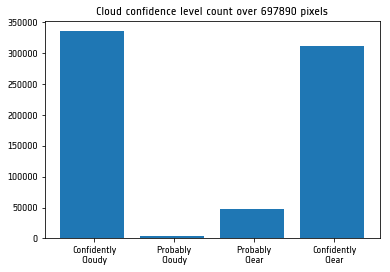

In [20]:
vcm_measurements = ['vcm_confidently_cloudy', 
                    'vcm_probably_cloudy', 
                    'vcm_probably_clear', 
                    'vcm_confidently_clear']
  
# sum cloud mask information values for all scaled field of views
for vcm_measurement in vcm_measurements:
    snpp[vcm_measurement+'_sum'] =\
        snpp[vcm_measurement].sum(dim='scaled_field_of_view')

cloud_confidence = np.array([snpp['vcm_confidently_cloudy_sum'].values.flatten(),
                             snpp['vcm_probably_cloudy_sum'].values.flatten(),
                             snpp['vcm_probably_clear_sum'].values.flatten(),
                             snpp['vcm_confidently_clear_sum'].values.flatten()])

# for each pixel, assign cloud confidence value depending on the max pixel count 
# of the four cloud mask classification variables
snpp['cloud_confidence'] = xr.DataArray(
    np.argmax(cloud_confidence, axis=0).reshape(snpp.vcm_confidently_cloudy_sum.shape), 
    dims=['time', 'scanline', 'ground_pixel'])

unique, counts = np.unique(np.argmax(cloud_confidence, axis=0), 
                           return_counts=True)

plt.bar(unique, counts)
plt.xticks(unique+0.05/2, ['Confidently\nCloudy', 'Probably\nCloudy', 
                            'Probably\nClear', 'Confidently\nClear'])
plt.title("Cloud confidence level count over {} pixels".format(counts.sum()))
plt.show()

As we can see from the plot above, our TROPOMI pixels in this product have been classified as either confidently cloudy or confidently clear, with a very little percentage of probably clear pixels and an even smaller percentage of probably cloudy pixels.

## Plotting the data 

What follows is a quite elaborate plot definition. It took me a while to get it the way I wanted it to look. 
My biggest struggle was to get the two colour bars to be placed one at the bottom of the plot, and one on the right side. I finally managed it by creating a dedicated axes for the cloud mask colour bar and by passing the `cbar_kwargs` arguments to the xarray's plot function, which in turns calls the underlying matplotlib function.


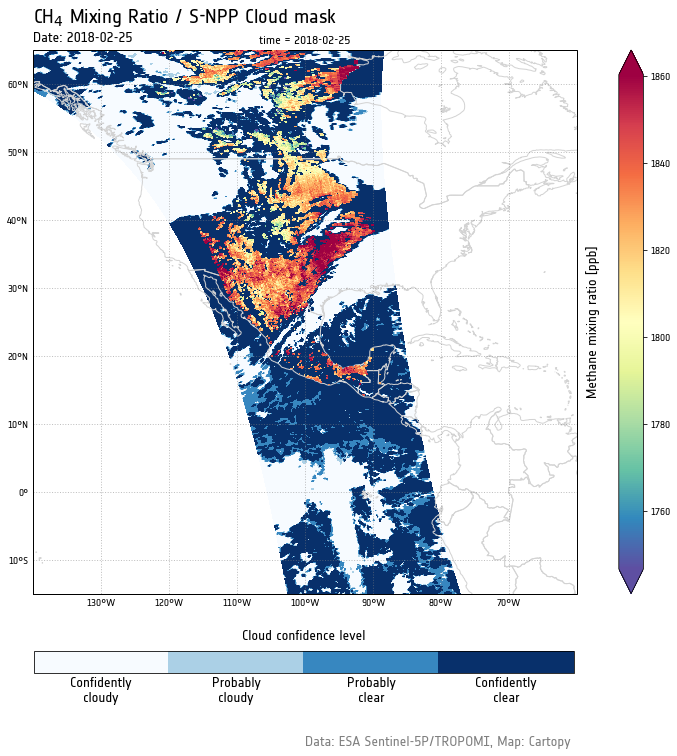

In [22]:
figure, ax = plt.subplots(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

# define plot extent
plot_extent = (-140, -60, -15, 65)

ax.set_extent(plot_extent, ccrs.PlateCarree())

# define Natural Earth features
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none')

land_10m = cfeature.NaturalEarthFeature(
    category='physical', 
    name='land', 
    scale='50m',
    edgecolor='face',
    facecolor=cfeature.COLORS['land'])

# set map background and features
ax.add_feature(states_provinces, edgecolor='lightgray')

# create axes for the cloud plot    
cloud_cbax = figure.add_axes([0.242, 0.015, 0.5, 0.03]) 

# Cloud mask plot
cloud_plot = snpp['cloud_confidence'].isel(time=0).plot.contourf(ax=ax, 
                                            transform=ccrs.PlateCarree(),
                                            cmap=plt.cm.get_cmap('Blues'),
                                            cbar_kwargs={'cax': cloud_cbax, \
                                                         'orientation': 'horizontal'},
                                            x='longitude', 
                                            y='latitude',
                                            levels = [-1, 0, 1, 2, 3])

# cloud mask colorbar properties
cloud_cbar = cloud_plot.colorbar
cloud_cbar.ax.get_xaxis().set_ticks([0, 0.125, 0.375, 0.625, 0.875])
cloud_cbar.ax.tick_params(axis=u'both', which=u'both',length=0)
cloud_cbar.ax.set_xticklabels(['', 'Confidently\ncloudy', 'Probably\ncloudy', 
                               'Probably\nclear', 'Confidently\nclear'], size=14)
cloud_cbar.ax.set_xlabel('Cloud confidence level', labelpad=-75, size = 14)


# CH4 plot
ch4_plot = ch4['methane_mixing_ratio'].isel(time=0).plot.pcolormesh(ax=ax, 
                                            transform=ccrs.PlateCarree(),
                                            x='longitude', 
                                            y='latitude',
                                            cmap=plt.get_cmap('Spectral_r'),
                                            vmin=ch4['methane_mixing_ratio'].quantile(0.05),
                                            vmax=ch4['methane_mixing_ratio'].quantile(0.95), zorder=3)                                            

# CH4 colorbar properties
ch4_cbar = ch4_plot.colorbar
ch4_cbar.ax.set_ylabel('Methane mixing ratio [ppb]', labelpad=-85, size=14)


# Gridlines definition
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plot title/subtitle/caption
plt.title('')
ax.text(0, 1.05, r"CH$_4$ Mixing Ratio / S-NPP Cloud mask", fontsize=20, transform=ax.transAxes)
ax.text(0, 1.015, r"Date: {}".format(str(ch4.time.data[0]).split('T')[0]), fontsize=14, transform=ax.transAxes)
ax.text(0.5, -0.28, r"Data: ESA Sentinel-5P/TROPOMI,"
        " Map: Cartopy", fontsize=14, color='gray', transform=ax.transAxes)

plt.show()

From a quick visual check, we can indeed observe that the CH4 measurements have been acquired on land and cloud free areas only.

## Conclusion

In this post, we showed how to use xarray to easily open and manipulate NetCDF4 files, and how to superimpose two  products on a single a publication ready plot with Matplotlib and cartopy.

I hope you enjoyed it, and feel free to comment if you have questions or remarks.

_This post was written entirely in a Jupyter notebook. You can download it on my [GitHub repository](https://github.com/stefanomattia/jupyter-notebooks/tree/master/earth-observation)._